### fastai steps
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

### Imports

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from fastai.model import *

### Setup

In [6]:
PATH = "data/dog_breeds/"
sz = 224
bs = 58 # batch size
arch= resnext101_64

#### Expore Data

In [7]:
os.listdir(f'{PATH}')

['labels.csv.zip',
 'models',
 'sample_submission.csv.zip',
 'test',
 'test.zip',
 'tmp',
 'train',
 'train.zip']

In [8]:
labels = pd.read_csv(f'{PATH}labels.csv.zip')
val_idxs = get_cv_idxs(len(labels)) # get validation idx
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
labels.pivot_table(index='breed', aggfunc=len).sort_values(by='id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [10]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', 
                                        test_name='test',
                                        csv_fname=f'{PATH}labels.csv.zip',
                                        suffix='.jpg', 
                                        val_idxs=val_idxs,
                                        tfms=tfms, bs=bs)
    return data
data = get_data(sz, bs)

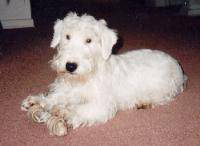

In [11]:
def show_image(data, i):
    fn = data.path + data.trn_ds.fnames[i]
    return PIL.Image.open(fn)
show_image(data, np.random.randint(len(labels)))

### Precomputed run
Precompute uses the precompute values for each image for the base architecture and then trains the final layer. Purely a speed boost. You can't use this with data augmentation because the precomputed values for each augmented images will be (obviously) incorrect

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [01:42<00:00,  1.74it/s]


In [20]:
# find learning rate
learn.lr_find()

 85%|████████▌ | 120/141 [00:00<00:00, 162.31it/s, loss=2.51]


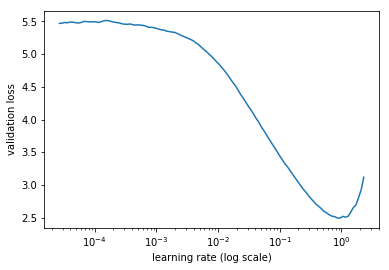

In [21]:
learn.sched.plot()
lr = .01

In [22]:
learn.fit(lr, n_cycle=5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.92233    0.36953    0.917808  
    1      0.410596   0.284038   0.922211                     
    2      0.281071   0.261109   0.920744                     
    3      0.219272   0.242659   0.922701                     
    4      0.178839   0.23523    0.924168                     



[array([0.23523]), 0.9241682982141491]

### Turn precompute off
After a first run with precomputed values, turn it off (our final layer weights should be closer to the right place), and fit with data augmentation on

In [23]:
learn.precompute=False
learn.fit(lr, n_cycle=3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.248087   0.225129   0.925147  
    1      0.220248   0.222968   0.926125                    
    2      0.211351   0.219136   0.924168                    



[array([0.21914]), 0.9241682999054747]

In [ ]:
# stochastic gradient descent with restarts. Restarts 3 times (n_cycle), with one epoch (cycle_len) between each restart
learn.sched.plot_lr()

###  Unfreeze weights
Up until this point we have used frozen weights from resnet34. This means that the convolutional layers have not changed their weights at all. This is reasonable given that it was trained on ImageNet, and our current dataset is very similar to ImageNet (in fact, it is a subset of ImageNet).

But now we unfreeze the weights to finetune the entire network

In [34]:
learn.unfreeze()

we can provide an array of learning rates - one for "early" convolutional layers, one for "mid", and one for our final FC layers. We also are trying a different LR scheduler. This one uses cycle_mult=2, which lengthens the cycle_len by a factor of 2 each time before resetting.


In [35]:
lrs = [lr/9, lr/3, lr]
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.282653   0.750239   0.772994  
    1      1.361617   993450.237158 0.007339                
    2      5.578055   4.830429   0.014188                   
 56%|█████▌    | 164/293 [00:27<00:21,  5.88it/s, loss=5.42]

KeyboardInterrupt: 

In [51]:
log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
accuracy_np(preds, y)

0.8312133072407045